In [1]:
!pip install d2l

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l
d2l.use_svg_display()

# reading the Dataset

In [6]:
trans = transforms.ToTensor()
USPS_train = torchvision.datasets.USPS(
  root="../data", train=True, transform=trans, download=True)
USPS_test = torchvision.datasets.USPS(
  root="../data", train=False, transform=trans, download=True)

In [7]:
len(USPS_train), len(USPS_test)

(7291, 2007)

In [8]:
USPS_train[0][0].shape

torch.Size([1, 16, 16])

In [18]:
def get_USPS_labels(labels):
  text_labels = ['0', '1', '2', '3', '4',
  '5', '6', '7', '8', '9']
  return [text_labels[int(i)] for i in labels]

In [19]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
  figsize = (num_cols * scale, num_rows * scale)
  _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
  axes = axes.flatten()
  for i, (ax, img) in enumerate(zip(axes, imgs)):
    if torch.is_tensor(img):
      # Tensor Image
      ax.imshow(img.numpy())
    else:
      # PIL Image
      ax.imshow(img)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    if titles:
      ax.set_title(titles[i])
  return axes

In [20]:
X, y = next(iter(data.DataLoader(USPS_train, batch_size=18)))

In [21]:
X.shape

torch.Size([18, 1, 16, 16])

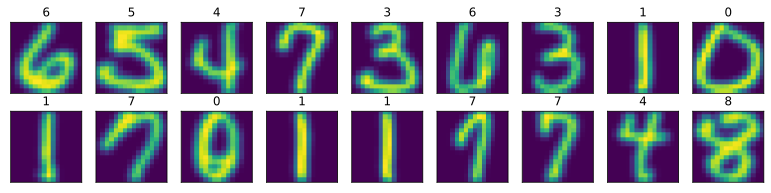

In [22]:
show_images(X.reshape(18, 16, 16), 2, 9, titles=get_USPS_labels(y));

In [24]:
batch_size = 256
def get_dataloader_workers():
  return 4

train_iter = data.DataLoader(USPS_train, batch_size, shuffle=True,
num_workers=get_dataloader_workers())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [25]:
timer = d2l.Timer()
for X, y in train_iter:
  continue
f'{timer.stop():.2f} sec'

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


'0.75 sec'

In [28]:
def load_data_USPS(batch_size, resize=None):
  trans = [transforms.ToTensor()]
  if resize:
    trans.insert(0, transforms.Resize(resize))
  trans = transforms.Compose(trans)
  USPS_train = torchvision.datasets.USPS(
    root="../data", train=True, transform=trans, download=True)
  USPS_test = torchvision.datasets.USPS(
    root="../data", train=False, transform=trans, download=True)
  return (data.DataLoader(USPS_train, batch_size, shuffle=True,
num_workers=get_dataloader_workers()),
data.DataLoader(USPS_test, batch_size, shuffle=False,
num_workers=get_dataloader_workers()))

In [29]:
train_iter, test_iter = load_data_USPS(32, resize=64)
for X, y in train_iter:
  print(X.shape, X.dtype, y.shape, y.dtype)
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


In [30]:
import torch
from IPython import display
from d2l import torch as d2l

In [31]:
batch_size = 256
train_iter, test_iter = load_data_USPS(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [55]:
num_inputs = 256
num_outputs = 10
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [56]:
def softmax(X):
  X_exp = torch.exp(X)
  partition = X_exp.sum(1, keepdim=True)
  return X_exp / partition

In [57]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.6200, 0.0422, 0.3134, 0.0083, 0.0162],
         [0.0895, 0.1254, 0.0880, 0.0982, 0.5989]]), tensor([1.0000, 1.0000]))

In [58]:
def net(X):
  return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [59]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [60]:
def cross_entropy(y_hat, y):
  return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [61]:
def evaluate_accuracy(net, data_iter):
  if isinstance(net, torch.nn.Module):
    net.eval() # Set the model to evaluation mode
  metric = Accumulator(2) # No. of correct predictions, no. of predictions
  with torch.no_grad():
    for X, y in data_iter:
      metric.add(d2l.accuracy(net(X), y), y.numel())
  return metric[0] / metric[1]


In [62]:
class Accumulator:
  def __init__(self, n):
    self.data = [0.0] * n
  def add(self, *args):
    self.data = [a + float(b) for a, b in zip(self.data, args)]
  def reset(self):
    self.data = [0.0] * len(self.data)
  def __getitem__(self, idx):
    return self.data[idx]

In [63]:
evaluate_accuracy(net, test_iter)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.09965122072745392

In [64]:
def train_epoch_ch3(net, train_iter, loss, updater):
  if isinstance(net, torch.nn.Module):
    net.train()
  # Sum of training loss, sum of training accuracy, no. of examples
  metric = Accumulator(3)
  for X, y in train_iter:
    # Compute gradients and update parameters
    y_hat = net(X)
    l = loss(y_hat, y)
    if isinstance(updater, torch.optim.Optimizer):
      # Using PyTorch in-built optimizer & loss criterion
      updater.zero_grad()
      l.mean().backward()
      updater.step()
    else:
      # Using custom built optimizer & loss criterion
      l.sum().backward()
      updater(X.shape[0])
      metric.add(float(l.sum()), d2l.accuracy(y_hat, y), y.numel())
  # Return training loss and training accuracy
  return metric[0] / metric[2], metric[1] / metric[2]

In [65]:
class Animator:
  def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
               ylim=None, xscale='linear', yscale='linear',
               fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
               figsize=(3.5, 2.5)):
    # Incrementally plot multiple lines
    if legend is None:
      legend = []
    d2l.use_svg_display()
    self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
    if nrows * ncols == 1:
      self.axes = [self.axes, ]
    # Use a lambda function to capture arguments
    self.config_axes = lambda: d2l.set_axes(
      self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
    self.X, self.Y, self.fmts = None, None, fmts

def add(self, x, y):
  # Add multiple data points into the figure
  if not hasattr(y, "__len__"):
    y = [y]
  n = len(y)
  if not hasattr(x, "__len__"):
    x = [x] * n
  if not self.X:
    self.X = [[] for _ in range(n)]
  if not self.Y:
    self.Y = [[] for _ in range(n)]
  for i, (a, b) in enumerate(zip(x, y)):
    if a is not None and b is not None:
      self.X[i].append(a)
      self.Y[i].append(b)
  self.axes[0].cla()
  for x, y, fmt in zip(self.X, self.Y, self.fmts):
    self.axes[0].plot(x, y, fmt)
  self.config_axes()
  display.display(self.fig)
  display.clear_output(wait=True)

In [66]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):
  animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                      legend=['train loss', 'train acc', 'test acc'])
  for epoch in range(num_epochs):
    train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
    test_acc = evaluate_accuracy(net, test_iter)
    animator.add(epoch + 1, train_metrics + (test_acc,))
  train_loss, train_acc = train_metrics
  assert train_loss < 0.5, train_loss
  assert train_acc <= 1 and train_acc > 0.7, train_acc
  assert test_acc <= 1 and test_acc > 0.7, test_acc

In [67]:
lr = 0.1

def updater(batch_size):
  return d2l.sgd([W, b], lr, batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


AttributeError: ignored

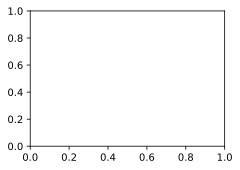

In [68]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


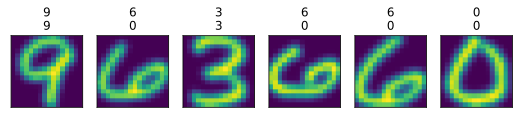

In [71]:
def predict_ch3(net, test_iter, n=6):
  for X, y in test_iter:
    break
  trues = get_USPS_labels(y)
  preds = get_USPS_labels(net(X).argmax(axis=1))
  titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
  d2l.show_images(
    X[0:n].reshape((n, 16, 16)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

In [72]:
import torch
from torch import nn
from d2l import torch as d2l

In [73]:
batch_size = 256
train_iter, test_iter = load_data_USPS(batch_size)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [75]:
net = nn.Sequential(nn.Flatten(), nn.Linear(256, 10))

def init_weights(m):
  if type(m) == nn.Linear:
    nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [76]:
loss = nn.CrossEntropyLoss(reduction='none')

In [77]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

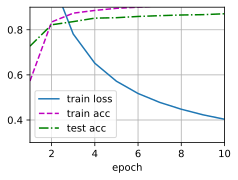

In [78]:
num_epochs = 10
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)